In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
model = models.resnet18()

In [4]:
BATCH_SIZE = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes

('airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

class BitLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(BitLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.randn(out_features) * 0.01)

    def forward(self, x):
        scale = 1.0 / self.weight.abs().mean().clamp(min=1e-5) 
        scaled_weight = self.weight * scale
        ternary_weight = torch.where(scaled_weight.abs() < 0.5, 0, torch.sign(scaled_weight))
        ternary_weight = ternary_weight / scale  
        return F.linear(x, ternary_weight, self.bias)

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),  
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        
        self.dropout = nn.Dropout(p=0.5)  
        
        self.fc = BitLinear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        
        out = self.dropout(out)
        
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)
net = ResNet18().to(device)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [9]:
all_iteration_losses = []
validation_accuracies = []
for epoch in range(20):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        all_iteration_losses.append(loss.item())

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 50 == 0:
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                  % (epoch + 1, (i + 1), sum_loss / (i + 1), 100. * correct / total))

    print('Testing...')
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total  
        print('Test Accuracy: %.3f%%' % test_acc) 
        validation_accuracies.append(test_acc)  

print('Training complete.')


Epoch: 1
[epoch:1, iter:50] Loss: 1.950 | Acc: 26.672% 
[epoch:1, iter:100] Loss: 1.823 | Acc: 31.805% 
[epoch:1, iter:150] Loss: 1.740 | Acc: 35.167% 
[epoch:1, iter:200] Loss: 1.670 | Acc: 37.934% 
[epoch:1, iter:250] Loss: 1.618 | Acc: 40.222% 
[epoch:1, iter:300] Loss: 1.568 | Acc: 42.260% 
[epoch:1, iter:350] Loss: 1.520 | Acc: 44.172% 
Testing...
Test Accuracy: 57.740%

Epoch: 2
[epoch:2, iter:50] Loss: 1.103 | Acc: 60.484% 
[epoch:2, iter:100] Loss: 1.085 | Acc: 61.172% 
[epoch:2, iter:150] Loss: 1.073 | Acc: 61.859% 
[epoch:2, iter:200] Loss: 1.054 | Acc: 62.559% 
[epoch:2, iter:250] Loss: 1.031 | Acc: 63.472% 
[epoch:2, iter:300] Loss: 1.012 | Acc: 64.141% 
[epoch:2, iter:350] Loss: 0.993 | Acc: 64.846% 
Testing...
Test Accuracy: 63.720%

Epoch: 3
[epoch:3, iter:50] Loss: 0.857 | Acc: 70.953% 
[epoch:3, iter:100] Loss: 0.828 | Acc: 71.461% 
[epoch:3, iter:150] Loss: 0.812 | Acc: 71.859% 
[epoch:3, iter:200] Loss: 0.801 | Acc: 72.254% 
[epoch:3, iter:250] Loss: 0.788 | Acc: 72

[57.74, 63.72, 72.24, 79.28, 81.67, 82.65, 82.85, 84.57, 84.17, 86.45, 87.0, 85.51, 87.61, 85.6, 83.11, 88.26, 87.29, 88.89, 89.96, 88.15]


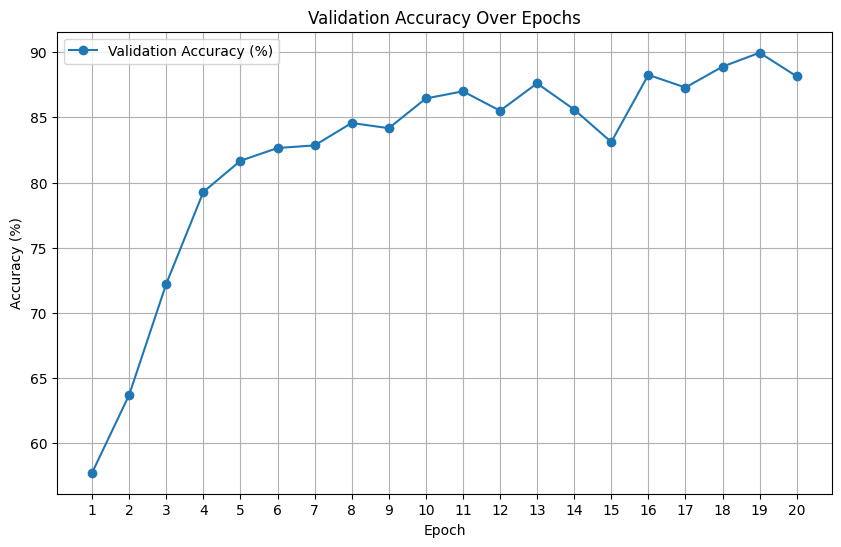

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print(validation_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy (%)', marker='o')

plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(validation_accuracies) + 1))  
plt.legend()
plt.grid()
plt.show()


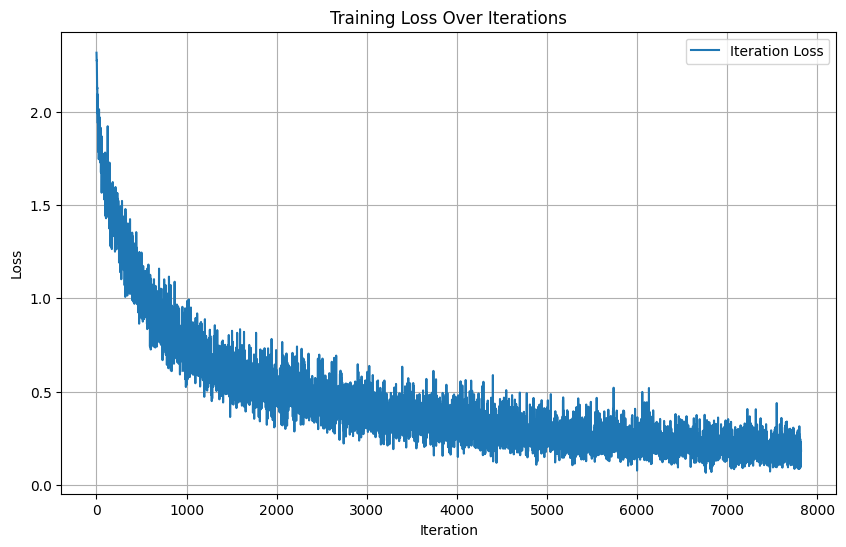

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(all_iteration_losses) + 1), all_iteration_losses, label='Iteration Loss')

# Add labels, title, and grid
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
